In [1]:
!pip install numpy pandas yfinance tensorflow scikit-learn matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import các thư viện
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")  # Bỏ qua cảnh báo không quan trọng

In [3]:
# TẢI DỮ LIỆU CỔ PHIẾU
ticker = 'AAPL'
data = yf.download(ticker, start='2025-01-01', end=datetime.datetime.today().strftime('%Y-%m-%d'))
data = data[['Close']]  # chỉ lấy giá đóng cửa

print("Dữ liệu tải về:", len(data), "ngày")
print(data.head())

[*********************100%***********************]  1 of 1 completed

Dữ liệu tải về: 213 ngày
Price            Close
Ticker            AAPL
Date                  
2025-01-02  242.987411
2025-01-03  242.499161
2025-01-06  244.133347
2025-01-07  241.353226
2025-01-08  241.841492


In [4]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [5]:
# Tạo tập huấn luyện (Training set)

training_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:int(training_data_len), :]

x_train, y_train = [], []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])  # 60 ngày trước đó
    y_train.append(train_data[i, 0])       # ngày kế tiếp

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [6]:
# Xây dựng mô hình LSTM

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # đầu ra 1 giá trị (Regression)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Huấn luyện mô hình

model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0926
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0274
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0183
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0146
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0174
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0142
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0127
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0103
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0120
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0114


In [8]:
# Dự báo multi-step (30 ngày tiếp theo)

last_60_days = scaled_data[-60:]
x_future = last_60_days.reshape((1, last_60_days.shape[0], 1))

future_predictions = []

for _ in range(30):  # Dự báo 30 ngày
    pred = model.predict(x_future)
    future_predictions.append(pred[0, 0])
    # Cập nhật chuỗi 60 ngày: bỏ ngày đầu, thêm dự đoán mới
    x_future = np.append(x_future[:, 1:, :], [[pred[0]]], axis=1)

# Chuyển lại về thang giá gốc
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

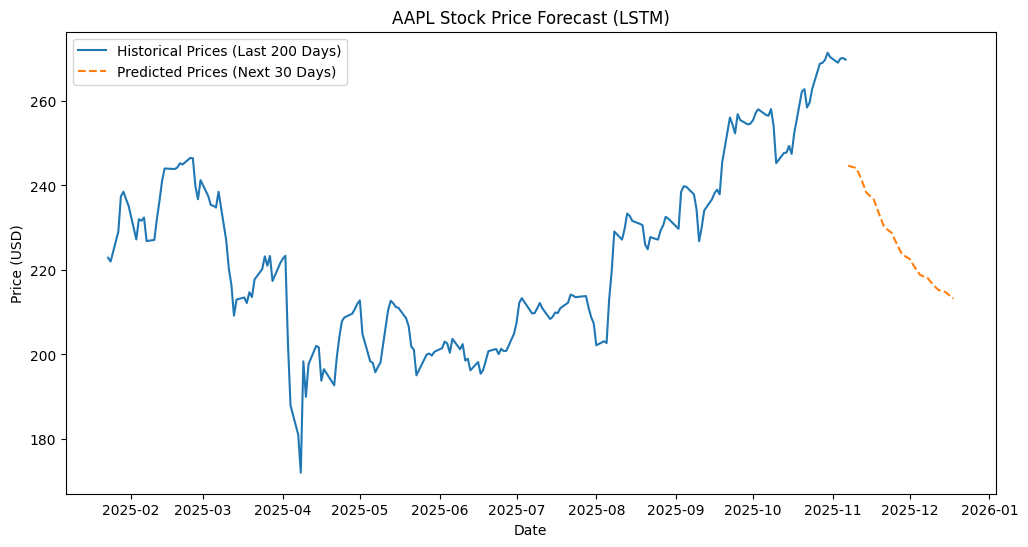

In [9]:
# Hiển thị kết quả dự báo
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast = pd.DataFrame(future_predictions, index=forecast_dates, columns=['Predicted Price'])

# Ghép lịch sử + dự báo để so sánh
plt.figure(figsize=(12, 6))
plt.plot(data['Close'].tail(200), label='Historical Prices (Last 200 Days)')
plt.plot(forecast, label='Predicted Prices (Next 30 Days)', linestyle='--')
plt.title(f"{ticker} Stock Price Forecast (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [10]:
# In bảng 30 ngày dự báo
print("\n Bảng dự báo 30 ngày tiếp theo:")
print(forecast)


 Bảng dự báo 30 ngày tiếp theo:
            Predicted Price
2025-11-07       244.657410
2025-11-10       244.144791
2025-11-11       243.065445
2025-11-12       241.650726
2025-11-13       240.051071
2025-11-14       238.363815
2025-11-17       236.652191
2025-11-18       234.956940
2025-11-19       233.304062
2025-11-20       231.709625
2025-11-21       230.183029
2025-11-24       228.729233
2025-11-25       227.350159
2025-11-26       226.045792
2025-11-27       224.814667
2025-11-28       223.654617
2025-12-01       222.562927
2025-12-02       221.536469
2025-12-03       220.572113
2025-12-04       219.666611
2025-12-05       218.816788
2025-12-08       218.019485
2025-12-09       217.271713
2025-12-10       216.570526
2025-12-11       215.913193
2025-12-12       215.297089
2025-12-15       214.719650
2025-12-16       214.178604
2025-12-17       213.671631
2025-12-18       213.196686
